<a href="https://colab.research.google.com/github/helmahdy/Advanced-Machine-Learning/blob/main/RNN_helmahdy__3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from google.colab import drive

# Preparing the IMBD data
> We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), and cut the reviews after only 150 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.











In [ ]:

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 150

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Restrict training samples to 100
x_train = x_train[0:100]

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
len(x_train)

100

In [ ]:
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 8)            80000     
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1201      
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 1s 109ms/step - loss: 0.6953 - acc: 0.4297 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/10
3/3 [==============================] - 0s 20ms/step - loss: 0.6652 - acc: 0.8930 - val_loss: 0.6932 - val_acc: 0.4500
Epoch 3/10
3/3 [==============================] - 0s 19ms/step - loss: 0.6439 - acc: 0.9516 - val_loss: 0.6938 - val_acc: 0

Results: training accuracy was 0.9938 compared to 0.8669 on the original model before making any changes. validation accuracy is 0.65 against 0.7554 for the original model. 

# Using pre-trained word embeddings

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels (positive / negative) into a labels list:
imdb_dir = '/content/gdrive/MyDrive/Colab Notebooks/aclImdb'
train_dir = os.path.join(imdb_dir,'train')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                

We then vectorize the texts we collected, and prepare a training and validation split. Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 100 samples. So we will be learning to classify movie reviews after looking at just 100 examples...

In [ ]:
maxlen = 150  # We will cut reviews after 150 words
training_samples = 100  # We will be training on 100 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 61971 unique tokens.
Shape of data tensor: (11877, 150)
Shape of label tensor: (11877,)


We will download the GloVe word embeddings, then we will Pre-process the embeddings by building an index mapping words (as strings) to their vector representation (as number vectors).


In [ ]:
glove_dir = '/content/gdrive/MyDrive/Colab Notebooks/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Then we build an embedding matrix that we will be able to load into an Embedding layer. It must be a matrix of shape (max_words, 
embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in our reference word index (built during tokenization)

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

# Now we move to building and compiling the model

In [ ]:
#Building the model 
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 15000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                480032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,480,065
Trainable params: 1,480,065
Non-trainable params: 0
_________________________________________________________________


Let's load the GloVe matrix we prepared into our Embedding layer, the first layer in our model. Then we freeze the embedding layer (we set its trainable attribute to False). when parts of a model are pre-trained (like Embedding layer), and parts are randomly initialized (like classifier), the pre-trained parts should not be updated during training to avoid forgetting what they already know


In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
#compling the model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
4/4 [==============================] - 2s 345ms/step - loss: 2.4332 - acc: 0.4871 - val_loss: 0.7088 - val_acc: 0.5823
Epoch 2/10
4/4 [==============================] - 1s 273ms/step - loss: 0.6441 - acc: 0.7293 - val_loss: 0.8556 - val_acc: 0.5822
Epoch 3/10
4/4 [==============================] - 1s 263ms/step - loss: 0.4880 - acc: 0.6729 - val_loss: 0.7301 - val_acc: 0.5826
Epoch 4/10
4/4 [==============================] - 1s 259ms/step - loss: 0.2600 - acc: 0.9314 - val_loss: 0.7771 - val_acc: 0.4671
Epoch 5/10
4/4 [==============================] - 1s 279ms/step - loss: 0.2588 - acc: 0.9444 - val_loss: 0.6691 - val_acc: 0.5908
Epoch 6/10
4/4 [==============================] - 1s 287ms/step - loss: 0.1242 - acc: 1.0000 - val_loss: 0.8844 - val_acc: 0.5825
Epoch 7/10
4/4 [==============================] - 1s 274ms/step - loss: 0.0662 - acc: 1.0000 - val_loss: 0.8231 - val_acc: 0.5839
Epoch 8/10
4/4 [==============================] - 1s 298ms/step - loss: 0.0390 - acc: 1.00

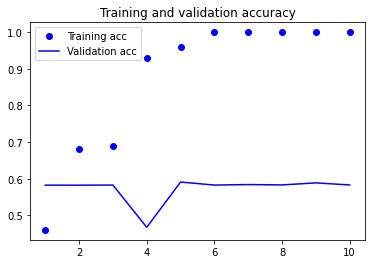

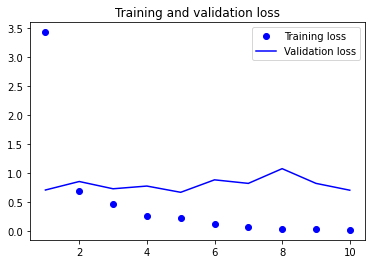

In [ ]:
#Let's plot its performance over time:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Train the same model without loading the pre-trained word embeddings

> Now we Train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings when lots of data is available. However, in our case, we have only 100 training samples.



In [ ]:
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                480032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,480,065
Trainable params: 1,480,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4/4 [==============================] - 2s 368ms/step - loss: 0.6852 - acc: 0.5973 - val_loss: 0.6965 - val_acc: 0.5824
Epoch 2/10
4/4 [==============================] - 1s 305ms/step - loss: 0.4143 - acc: 0.9006 - val_loss: 0.6826 

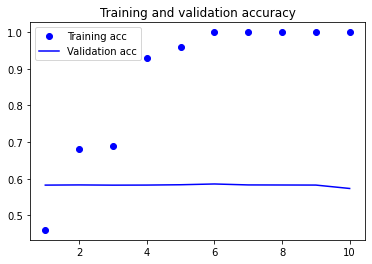

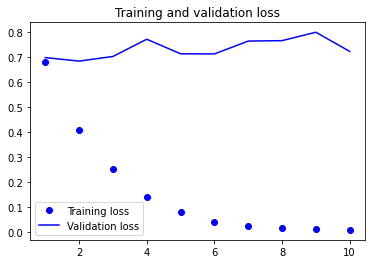

In [ ]:
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [ ]:
#And let's load and evaluate the first model:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

440/440 [==============================] - 2s 4ms/step - loss: 0.7251 - acc: 0.5684


[0.7251108288764954, 0.5684195756912231]

Results Summary:  for smaller training sample (only 100 sample), the pre-trained word embbeding model was overfitting but gave slightly better results than the task-specific embedding.